In [1]:
import random

def initialize_population(orders, stock_length, pop_size=10):
    population = []
    for _ in range(pop_size):
        individual = []
        random.shuffle(orders)  # Shuffle orders to create diversity
        pattern = []
        current_length = 0
        for size, quantity in orders:
            for _ in range(quantity):
                if current_length + size > stock_length:
                    individual.append(pattern)  # Add completed roll to individual
                    pattern = []  # Start a new roll
                    current_length = 0
                pattern.append(size)
                current_length += size
        if pattern:
            individual.append(pattern)  # Add last pattern to individual
        population.append(individual)
    return population


In [2]:
def calculate_fitness(patterns, stock_length):
    total_waste = 0
    for pattern in patterns:
        waste = stock_length - sum(pattern)
        if waste >= 0:
            total_waste += waste  # Only add valid waste
    return total_waste  # Lower waste is better


In [3]:
def selection(population, stock_length):
    fitness_scores = [(individual, calculate_fitness(individual, stock_length)) for individual in population]
    fitness_scores.sort(key=lambda x: x[1])
    selected = [individual for individual, score in fitness_scores[:len(fitness_scores) // 2]]
    return selected


In [4]:
# Crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 2)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2


# Mutation
def mutate(individual, mutation_rate=0.1):
    for pattern in individual:
        if random.random() < mutation_rate:
            random_size = random.choice([20, 40, 60, 80, 100])  # Example mutation cuts
            if sum(pattern) + random_size <= stock_length:
                pattern.append(random_size)
    return individual


In [5]:
def genetic_algorithm(orders, stock_length, generations=50, pop_size=10, mutation_rate=0.1):
    population = initialize_population(orders, stock_length, pop_size)
    best_wastes = []

    for generation in range(generations):
        # Fitness evaluation
        fitness_scores = [calculate_fitness(individual, stock_length) for individual in population]
        min_waste = min(fitness_scores)
        best_wastes.append(min_waste)
        print(f"Generation {generation} - Best Fitness (Least Waste): {min_waste}")

        # Selection
        parents = selection(population, stock_length)

        # Crossover and Mutation
        next_generation = []
        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            next_generation.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

        population = next_generation

    # Best solution
    best_pattern = min(population, key=lambda ind: calculate_fitness(ind, stock_length))
    best_fitness = calculate_fitness(best_pattern, stock_length)
    return best_pattern, best_fitness


In [6]:
import matplotlib.pyplot as plt

def plot_cutting_patterns(best_pattern, stock_length):
    plt.figure(figsize=(10, 6))
    for i, pattern in enumerate(best_pattern):
        current_length = 0
        for cut in pattern:
            plt.barh(i, cut, left=current_length, color='skyblue', edgecolor='black')
            current_length += cut
        waste = stock_length - sum(pattern)
        if waste > 0:
            plt.barh(i, waste, left=current_length, color='salmon', edgecolor='black')
    plt.xlabel('Length')
    plt.ylabel('Stock Rolls (Patterns)')
    plt.title('Cutting Patterns with Waste')
    plt.show()


Generation 0 - Best Fitness (Least Waste): 1000
Generation 1 - Best Fitness (Least Waste): 700
Generation 2 - Best Fitness (Least Waste): 700
Generation 3 - Best Fitness (Least Waste): 640
Generation 4 - Best Fitness (Least Waste): 480
Generation 5 - Best Fitness (Least Waste): 460
Generation 6 - Best Fitness (Least Waste): 380
Generation 7 - Best Fitness (Least Waste): 240
Generation 8 - Best Fitness (Least Waste): 240
Generation 9 - Best Fitness (Least Waste): 200
Generation 10 - Best Fitness (Least Waste): 140
Generation 11 - Best Fitness (Least Waste): 80
Generation 12 - Best Fitness (Least Waste): 40
Generation 13 - Best Fitness (Least Waste): 20
Generation 14 - Best Fitness (Least Waste): 20
Generation 15 - Best Fitness (Least Waste): 0
Generation 16 - Best Fitness (Least Waste): 0
Generation 17 - Best Fitness (Least Waste): 0
Generation 18 - Best Fitness (Least Waste): 0
Generation 19 - Best Fitness (Least Waste): 0
Generation 20 - Best Fitness (Least Waste): 0
Generation 21 - B

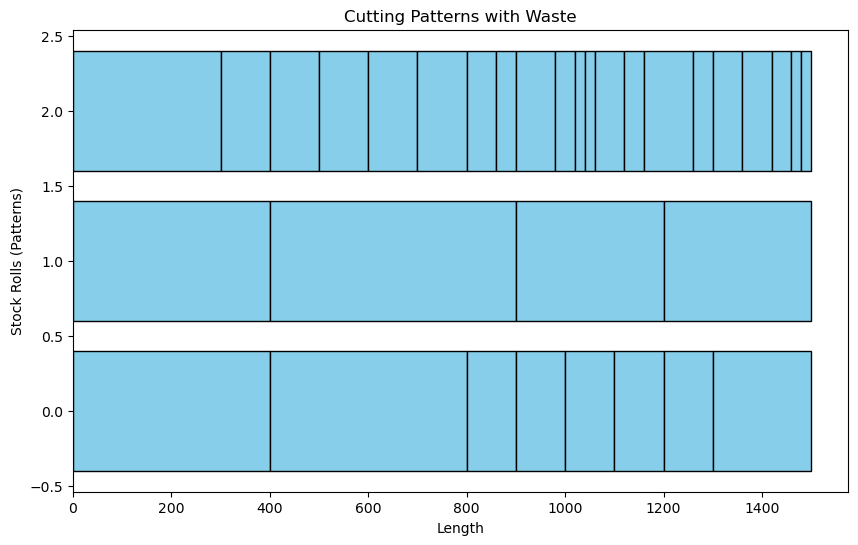

In [7]:
if __name__ == "__main__":
    orders = [(100, 5), (200, 4), (300, 3), (400, 2), (500, 1)]  # Example orders
    stock_length = 1500
    best_pattern, best_waste = genetic_algorithm(orders, stock_length)
    print("Best Pattern:", best_pattern)
    print("Best Waste:", best_waste)
    plot_cutting_patterns(best_pattern, stock_length)
